In [42]:
import csv
from os import listdir
import json
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from collections import defaultdict
import scipy.stats as stats

In [82]:
zeb1_eqtls = []
with open('../data/GTEx_ZEB1.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader) # skip header
    for pieces in reader:
        chrom, pos, ref, alt, build = pieces[2].split('_')
        if chrom == 'chr10' and len(ref) == 1 and len(alt) == 1 and 'Brain' in pieces[6] and '38' in build:
            zeb1_eqtls.append((pos, ref, alt))

ctbp2_eqtls = []
with open('../data/GTEx_CTBP2.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader) # skip header
    for pieces in reader:
        chrom, pos, ref, alt, build = pieces[2].split('_')
        if chrom == 'chr10' and len(ref) == 1 and len(alt) == 1 and 'Brain' in pieces[6] and '38' in build:
            ctbp2_eqtls.append((pos, ref, alt))

pos_of_interest = sorted(set([x[0] for x in zeb1_eqtls] + [x[0] for x in ctbp2_eqtls]))
print(len(pos_of_interest))

57


In [83]:
print(pos_of_interest)

['124969506', '124995565', '124997347', '124999801', '125000399', '125001814', '125002350', '125003624', '125007278', '125007927', '125008517', '125008641', '125016518', '125016689', '125018107', '125018613', '125018843', '125019312', '125019625', '125020214', '125022085', '125022222', '125022538', '125024046', '125025631', '125026145', '125026397', '125027777', '125028278', '125028301', '125028763', '125029781', '125030791', '125031007', '125031135', '125031264', '125031719', '125032872', '125033116', '125033385', '125033925', '125033966', '125037511', '125037766', '125037989', '125039834', '125041922', '125043167', '125045409', '125045546', '125049902', '125049964', '125603226', '30949274', '30951246', '31144345', '32291277']


In [84]:
chrom = '10'

data_dirs = [
             '../../DATA/ssc.hg38/genotypes/phase1-1',
             '../../DATA/ssc.hg38/genotypes/phase1-2',
             '../../DATA/ssc.hg38/genotypes/phase1-3',
             '../../DATA/ssc.hg38/genotypes/phase1-4',
             '../../DATA/ssc.hg38/genotypes/phase1-5',
             '../../DATA/ssc.hg38/genotypes/phase1-7',
             '../../DATA/ssc.hg38/genotypes/phase2',
             '../../DATA/ssc.hg38/genotypes/phase2_B01',
             '../../DATA/ssc.hg38/genotypes/phase2_Replacements',
             '../../DATA/ssc.hg38/genotypes/phase3_1',
             '../../DATA/ssc.hg38/genotypes/phase3_1_B02',
             '../../DATA/ssc.hg38/genotypes/phase3_2',
             '../../DATA/ssc.hg38/genotypes/phase4',
             '../../DATA/ssc.hg38/genotypes/pilot'
            ]
ped_file = '../../DATA/ssc.hg38/ssc.ped'

In [154]:
chrom = '10'

data_dirs = [
             '../../DATA/ihart.ms2/genotypes',
            ]
ped_file = '../../DATA/ihart.ms2/ihart.ped'

In [155]:
all_gen_data = []
all_sample_ids = []
for data_dir in data_dirs:
    print(data_dir)
    gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.npz' in f], key=lambda x: int(x.split('.')[2]))
    coord_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.coordinates.npy' in f], key=lambda x: int(x.split('.')[2]))
    af_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.af.npy' in f], key=lambda x: int(x.split('.')[2]))
    assert len(coord_files) == len(af_files)

    snp_positions, afs, gens = [], [], []
    for gen_file, coord_file, af_file in zip(gen_files, coord_files, af_files):
        coords = np.load('%s/%s' % (data_dir, coord_file))
        if coords.shape[0]>0:
            poss = coords[:, 1]
            is_snp = coords[:, 2]==1
            is_pass = coords[:, 3]==1
            has_data = np.where(is_snp & is_pass & (poss>=125500000) & (poss<=126000000))[0]
            if np.sum(has_data)>0:
                af = np.load('%s/%s' % (data_dir, af_file))
                gen = sparse.load_npz('%s/%s' % (data_dir, gen_file))[:, has_data].A
                
                snp_positions.append(poss[has_data])
                afs.append(-np.log10(af[has_data]))
                gens.append(gen)
    with open('%s/samples.json' % data_dir, 'r') as f:
        sample_ids = json.load(f)
    all_sample_ids.extend(sample_ids)

    gens = np.hstack(gens)
    snp_positions = np.hstack(snp_positions)
    afs = np.hstack(afs)
    all_gen_data.append(gens)
    print(gens.shape)
    

../../DATA/ihart.ms2/genotypes
(4610, 11663)


In [156]:
all_gen_data = np.vstack(all_gen_data)

In [157]:
has_data = np.any(all_gen_data>=0, axis=1)
all_gen_data = all_gen_data[has_data, :]
sample_ids = [sample_ids[i] for i in np.where(has_data)[0]]
print(all_gen_data.shape, len(sample_ids))

(4610, 11663) 4610


In [158]:
np.unique(all_gen_data, return_counts=True)

(array([-1,  0,  1,  2], dtype=int8),
 array([    2968, 51680918,  1347916,   734628]))

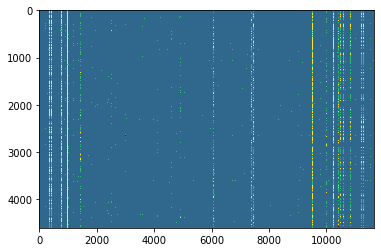

In [159]:
plt.imshow(all_gen_data, aspect='auto')
plt.show()

In [185]:
parents_to_children = defaultdict(list)
child_to_autism = dict()
with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[1] in all_sample_ids and pieces[2] in all_sample_ids and pieces[3] in all_sample_ids:
            parents_to_children[(pieces[3], pieces[2])].append(pieces[1])
            child_to_autism[pieces[1]] = pieces[5]
print(len(parents_to_children), len(child_to_autism))

885 2293


In [186]:
# TDT
sample_id_to_index = dict([(x, i) for i, x in enumerate(all_sample_ids)])

# pos, typ/aut, mat/pat
trans, notrans = np.zeros((all_gen_data.shape[1], 2, 2), dtype=int), np.zeros((all_gen_data.shape[1], 2, 2), dtype=int)

for (mom, dad), children in parents_to_children.items():
    mom_gen = all_gen_data[sample_id_to_index[mom], :]
    dad_gen = all_gen_data[sample_id_to_index[dad], :]
    
    for child in children:
        child_gen = all_gen_data[sample_id_to_index[child], :]
        trans[:, int(child_to_autism[child]=='2'), 0] += (mom_gen==1) & (dad_gen==0) & (child_gen==1)
        trans[:, int(child_to_autism[child]=='2'), 0] += (mom_gen==1) & (dad_gen==2) & (child_gen==2)
        notrans[:, int(child_to_autism[child]=='2'), 0] += (mom_gen==1) & (dad_gen==0) & (child_gen==0)
        notrans[:, int(child_to_autism[child]=='2'), 0] += (mom_gen==1) & (dad_gen==2) & (child_gen==1)
            
        trans[:, int(child_to_autism[child]=='2'), 1] += (dad_gen==1) & (mom_gen==0) & (child_gen==1)
        trans[:, int(child_to_autism[child]=='2'), 1] += (dad_gen==1) & (mom_gen==2) & (child_gen==2)
        notrans[:, int(child_to_autism[child]=='2'), 1] += (dad_gen==1) & (mom_gen==0) & (child_gen==0)
        notrans[:, int(child_to_autism[child]=='2'), 1] += (dad_gen==1) & (mom_gen==2) & (child_gen==1)
            
        #trans[:, int(child_to_autism[child]=='2'), ?] += (dad_gen==1) & (mom_gen==1) & (child_gen==1)
        trans[:, int(child_to_autism[child]=='2'), 0] += (dad_gen==1) & (mom_gen==1) & (child_gen==2)
        trans[:, int(child_to_autism[child]=='2'), 1] += (dad_gen==1) & (mom_gen==1) & (child_gen==2)
        #notrans[:, int(child_to_autism[child]=='2'), ?] += (dad_gen==1) & (mom_gen==1) & (child_gen==1)
        notrans[:, int(child_to_autism[child]=='2'), 0] += (dad_gen==1) & (mom_gen==1) & (child_gen==0)
        notrans[:, int(child_to_autism[child]=='2'), 1] += (dad_gen==1) & (mom_gen==1) & (child_gen==0)
       

In [194]:
# pos, typ/aut, mat/pat/both
pvalues = np.ones((all_gen_data.shape[1], 2, 3))
for i in range(all_gen_data.shape[1]):
    #pvalues[i] = stats.chi2_contingency([[trans_aut[i], notrans_aut[i]], [
    #                               trans_typ[i], notrans_typ[i]]])[1]
    pvalues[i, 0, 0] = stats.binom_test(trans[i, 0, 0], trans[i, 0, 0]+notrans[i, 0, 0])
    pvalues[i, 0, 1] = stats.binom_test(trans[i, 0, 1], trans[i, 0, 1]+notrans[i, 0, 1])
    pvalues[i, 0, 2] = stats.binom_test(trans[i, 0, 0]+trans[i, 0, 1], trans[i, 0, 0]+notrans[i, 0, 0]+trans[i, 0, 1]+notrans[i, 0, 1])
    pvalues[i, 1, 0] = stats.binom_test(trans[i, 1, 0], trans[i, 1, 0]+notrans[i, 1, 0])
    pvalues[i, 1, 1] = stats.binom_test(trans[i, 1, 1], trans[i, 1, 1]+notrans[i, 1, 1])
    pvalues[i, 1, 2] = stats.binom_test(trans[i, 1, 0]+trans[i, 1, 1], trans[i, 1, 0]+notrans[i, 1, 0]+trans[i, 1, 1]+notrans[i, 1, 1])
    
    try:
        chi_pvalues[i] = stats.chi2_contingency([[trans[i, 0, 0]+trans[i, 0, 1], 
                                              trans[i, 1, 0]+trans[i, 1, 1]],
                                             [notrans[i, 0, 0]+notrans[i, 0, 1], 
                                              notrans[i, 1, 0]+notrans[i, 1, 1]]])[1]
    except:
        pass
                                             
                                             

In [188]:
chi_pvalues = np.ones((all_gen_data.shape[1],))
for i in range(all_gen_data.shape[1]):
    if np.sum(trans[i, :, :]) + np.sum(notrans[i, :, :]) > 10:
        try:
            chi_pvalues[i] = stats.chi2_contingency([[trans[i, 0, 0]+trans[i, 0, 1], 
                                                  trans[i, 1, 0]+trans[i, 1, 1]],
                                                 [notrans[i, 0, 0]+notrans[i, 0, 1], 
                                                  notrans[i, 1, 0]+notrans[i, 1, 1]]])[1]
        except:
            pass

In [189]:
print(np.nanmin(chi_pvalues)*np.sum(chi_pvalues != 1))
print(np.min(pvalues[:, 0, 2])*all_gen_data.shape[1]*4)
print(np.min(pvalues[:, 1, 2])*all_gen_data.shape[1]*4)

0.03294946386390068
46652.0
46652.0


In [195]:
indices = np.any(pvalues[:, :, 2]<0.05/(all_gen_data.shape[1]*2), axis=1)
print(snp_positions[indices])

[125515660 125569189 125569358 125618955 125636160 125834787 125890568
 125890669 125891677 125892110 125892562 125892576 125892579 125892678
 125892798 125893135 125903099 125906520 125906524 125906526 125906527
 125908951 125908954 125918557 125918560 125919198 125936437 125964189
 125964190]


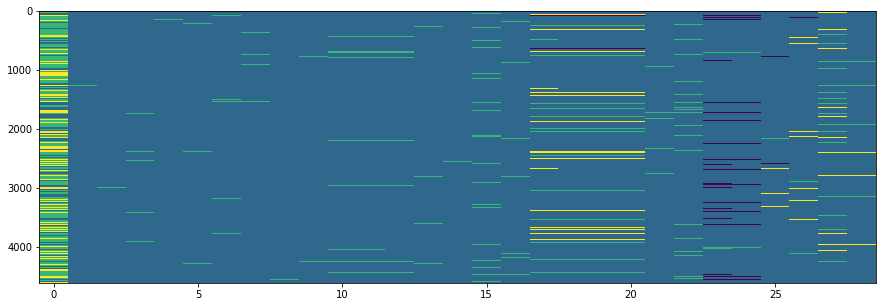

In [196]:
plt.figure(figsize=(15, 5))
plt.imshow(all_gen_data[:, indices], aspect='auto')
plt.show()

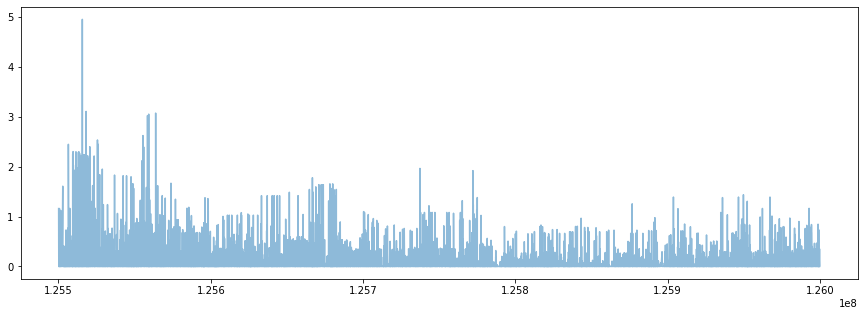

In [192]:
plt.figure(figsize=(15, 5))
#plt.plot(snp_positions, -np.log10(pvalues[:, 0, 2]), alpha=0.5)
plt.plot(snp_positions, -np.log10(chi_pvalues), alpha=0.5)
plt.show()

In [193]:
print(snp_positions[np.nanargmin(chi_pvalues)])

125515660


In [153]:
print(snp_positions[np.nanargmin(chi_pvalues)])

125817251


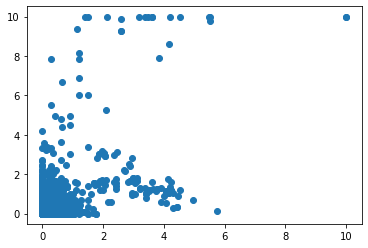

In [198]:
plt.scatter(np.clip(-np.log10(pvalues[:, 0, 2]), 0, 10), 
            np.clip(-np.log10(pvalues[:, 1, 2]), 0, 10))